In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys, os
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
from hop.instance.tsiligirides import TsiligiridesInstance

In [5]:
df = pd.read_csv('ans-bounds.csv')

In [6]:
df['frac_det_customers'] = df.n_det_customers / df.n_customers
df['avg_pct_travel_time_after_det_cust'] = 100 * df.avg_travel_time_after_det_cust / df.tour_duration
df['avg_pct_travel_time_after_tb_cust'] = 100 * df.avg_travel_time_after_tb_cust / df.tour_duration
# We multiply by 1000 otherwise it's impossible to see the data in the heatmap
df['avg_visited_lambda'] = 1000 * df.avg_visited_tb_lambda * df.pct_custs_visited_which_are_tb / 100

In [7]:
metrics = {
    'pct_time_bound_used': '%T used',
    'pct_profit_collected': '%p collected',
    'pct_custs_visited_which_are_tb': '% visited TB',
    'avg_pct_travel_time_after_det_cust': '%tt after det',
    'avg_pct_travel_time_after_tb_cust': '%tt after TB',
    'avg_visited_lambda': r'Avg $\lambda$ of visited $\times 10^3$'
}

params = ['tsiligirides_hop_alpha', 'tsiligirides_hop_beta']

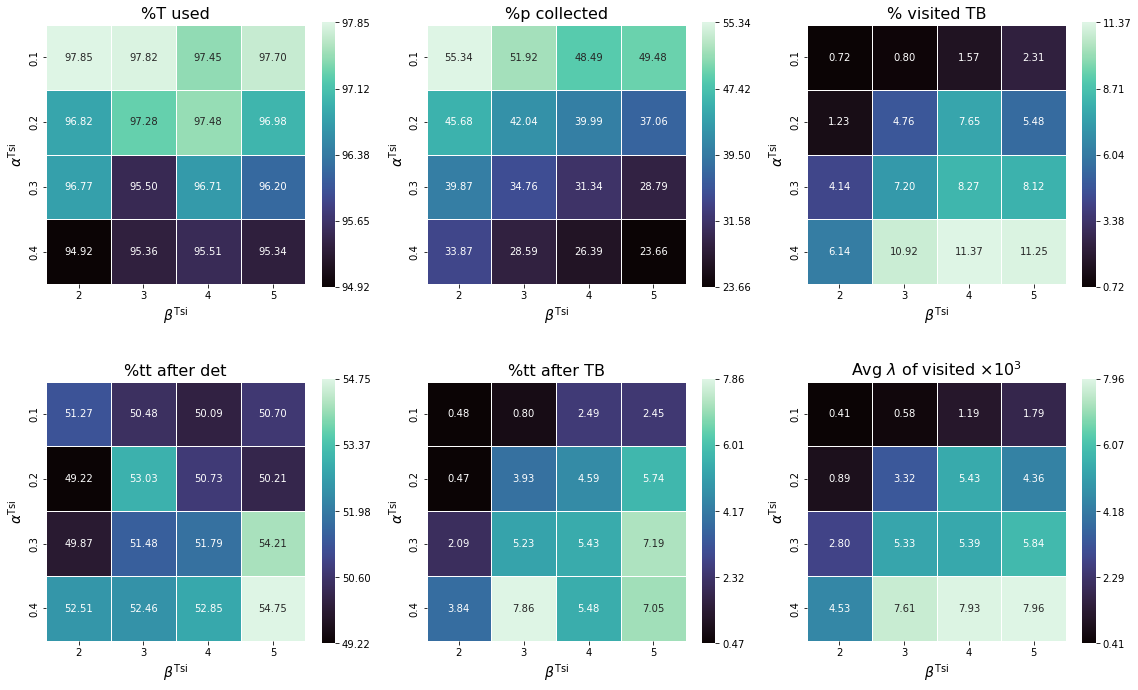

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

for idx, (metric, name) in enumerate(metrics.items()):
    ax = axes.flat[idx]
    table = df.pivot_table(index=params[0], columns=params[1], values=metric)
    
    sns.heatmap(
        table,
        cmap='mako',
        square=True,
        annot=True,
        fmt='.2f',
        linewidth=1,
        cbar_kws=dict(
            shrink=0.83,
            format='%.2f',
            ticks=np.linspace(table.min().min(), table.max().max(), num=5)
        ),
        ax=ax)
    
    ax.set_xlabel(r'$\beta^{\mathrm{Tsi}}$', fontsize=14)
    ax.set_ylabel(r'$\alpha^{\mathrm{Tsi}}$', fontsize=14)
    ax.set_title(name, fontsize=16)
    
fig.tight_layout();

In [12]:
def print_instance(instance, ax):
    cols = ['blue' if l == 0 else 'orange' for l in instance.l[1:]]
    ax.scatter([instance.xs[0]], [instance.ys[0]], color='red', marker='s')
    ax.scatter(instance.xs[1:], instance.ys[1:], color=cols, s=instance.p[1:])
    return ax

def print_tour(tour, instance, ax, title):
    for _, (i, j) in enumerate(zip(tour[:-1], tour[1:])):
        ax.plot([instance.xs[i], instance.xs[j]], [instance.ys[i], instance.ys[j]], color='black')
    ax.set_title(title)
    return ax

In [13]:
op_num = 3
op_tb = 75
hop_alpha = 0.2

tours = df[
    (df.tsiligirides_op_num == op_num) &
    (df.tsiligirides_op_tb == op_tb) &
    (df.tsiligirides_hop_alpha == hop_alpha)
][[
    'instance_file',
    'tsiligirides_hop_beta',
    'tour',
    'obj',
    'pct_profit_collected',
    'pct_custs_visited_which_are_tb'
]]\
.copy()\
.reset_index(drop=True)\
.sort_values('tsiligirides_hop_beta')

In [14]:
instances = [TsiligiridesInstance.load(filename=f'../data/hop-tsiligirides/hop_tsiligirides-{op_num}-{op_tb}-{hop_alpha}-{hop_beta}.json') for hop_beta in tours.tsiligirides_hop_beta.unique()]

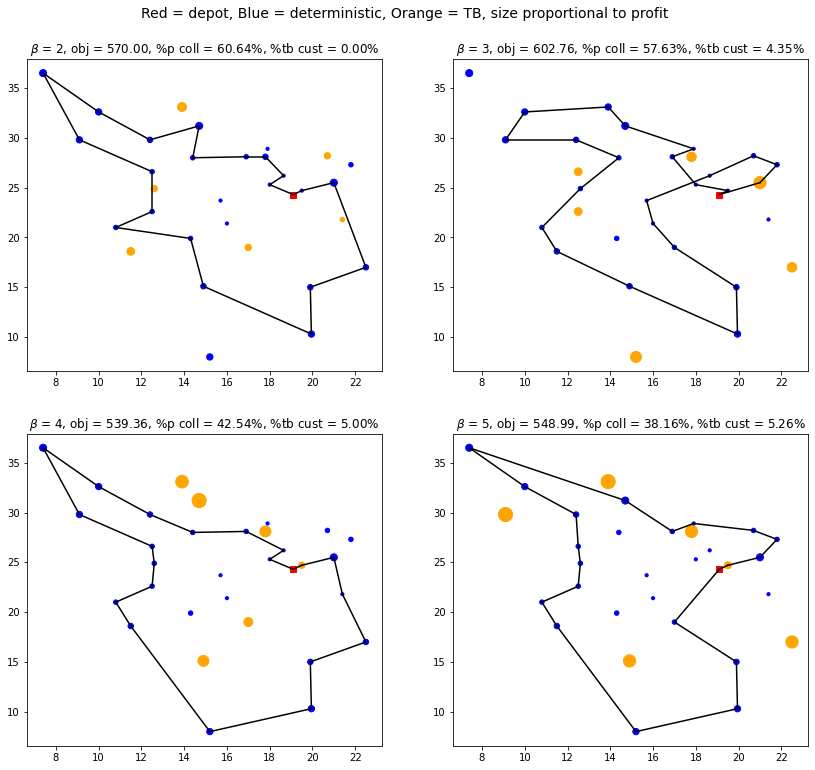

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,12))

for (_, row), instance, ax in zip(tours.iterrows(), instances, axes.flat):
    tour = [int(i) for i in row.tour.split(',')]
    title = fr"$\beta$ = {row.tsiligirides_hop_beta}, obj = {row.obj:.2f}, %p coll = {row.pct_profit_collected:.2f}%, %tb cust = {row.pct_custs_visited_which_are_tb:.2f}%"
    
    ax = print_instance(instance, ax)
    ax = print_tour(tour, instance, ax, title=title)
    
fig.suptitle('Red = depot, Blue = deterministic, Orange = TB, size proportional to profit', fontsize=14)
fig.subplots_adjust(top=0.92);